# Image Classification for Cat & Dog

## Overview

I have tried two different aproaches: 
- manually build a CNN and 
- use transfer learning based on different existing model.

For transfer learning, I have tried:
- Xception, 
- VGG16, 
- EfficientNetB3 and 
- EfficientNetB7. 

For each model, I will first freeze the original parameters in the first train, and then train all the parameters together in the second train, so as to tune the existing model fit this problem better.

After comparing the performance, the best submission is Xception.

## Data preprocess

In [1]:
!pip install kaggle

!mkdir kaggle
import json
token = {"username":"lanniec","key":"0b10b05b78bfc9525eaeb9bea3ff4b93"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv /content/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           4765        150  1.0              
mvieira101/global-cost-of-living                                Global Cost of Living                                 1MB  2022-12-03 16:37:53            632         32  0.9705882        
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset        

In [2]:
! kaggle competitions download -c 'dogs-vs-cats-redux-kernels-edition' -p /content/kaggle

100% 813M/814M [00:38<00:00, 18.7MB/s]
100% 814M/814M [00:38<00:00, 22.3MB/s]


In [3]:
!ls /content

kaggle	sample_data


In [4]:
!unzip kaggle/dogs-vs-cats-redux-kernels-edition.zip

Archive:  kaggle/dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [5]:
!unzip train.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/552.jpg            

In [6]:
ls -l -t train | head -3

total 608504
-rw-r--r-- 1 root root 29133 Sep 20  2013 cat.9993.jpg
-rw-r--r-- 1 root root 30029 Sep 20  2013 cat.9994.jpg


In [7]:
ls -l -t test | head -3

total 303992
-rw-r--r-- 1 root root 21471 Sep 20  2013 12498.jpg
-rw-r--r-- 1 root root 24012 Sep 20  2013 12499.jpg


In [8]:
cd train

/content/train


In [9]:
mkdir cat dog

In [10]:
!mv  ./dog.* ./dog
!mv  ./cat.* ./cat

In [11]:
from keras.preprocessing.image import ImageDataGenerator
val_batch = 10
train_batch = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.4,
        zoom_range=0.3,
        validation_split=0.30,
        horizontal_flip=True,
        )
train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(130, 130),
        batch_size=train_batch,
        class_mode='binary',
        subset = 'training',
        color_mode = 'rgb',
        shuffle = True,
        )
validation_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(130, 130),
        batch_size=val_batch,
        class_mode='binary',
        subset = 'validation',
        color_mode = 'rgb',
        shuffle= True)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [12]:
print(train_generator.class_indices)

{'cat': 0, 'dog': 1}


In [13]:
cd /content

/content


In [14]:
ls test | head -20

10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
1000.jpg
10010.jpg
10011.jpg
10012.jpg
10013.jpg
10014.jpg
10015.jpg
10016.jpg
10017.jpg
10018.jpg


In [15]:
import os
for i in os.listdir("test/"):
  os.rename("test/" + i, "test/" + i.split('.')[0].zfill(6) + '.jpg')
  test_images = ["test/"+i for i in os.listdir("test/")]
  test_images.sort()

In [16]:
ls test | head -20

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000013.jpg
000014.jpg
000015.jpg
000016.jpg
000017.jpg
000018.jpg
000019.jpg
000020.jpg


In [17]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        )

test_generator = test_datagen.flow_from_directory(
        '/content', classes=['test'],
        target_size=(130, 130),
        batch_size=train_batch,
        color_mode = 'rgb',
        shuffle = False,
        )

Found 12500 images belonging to 1 classes.


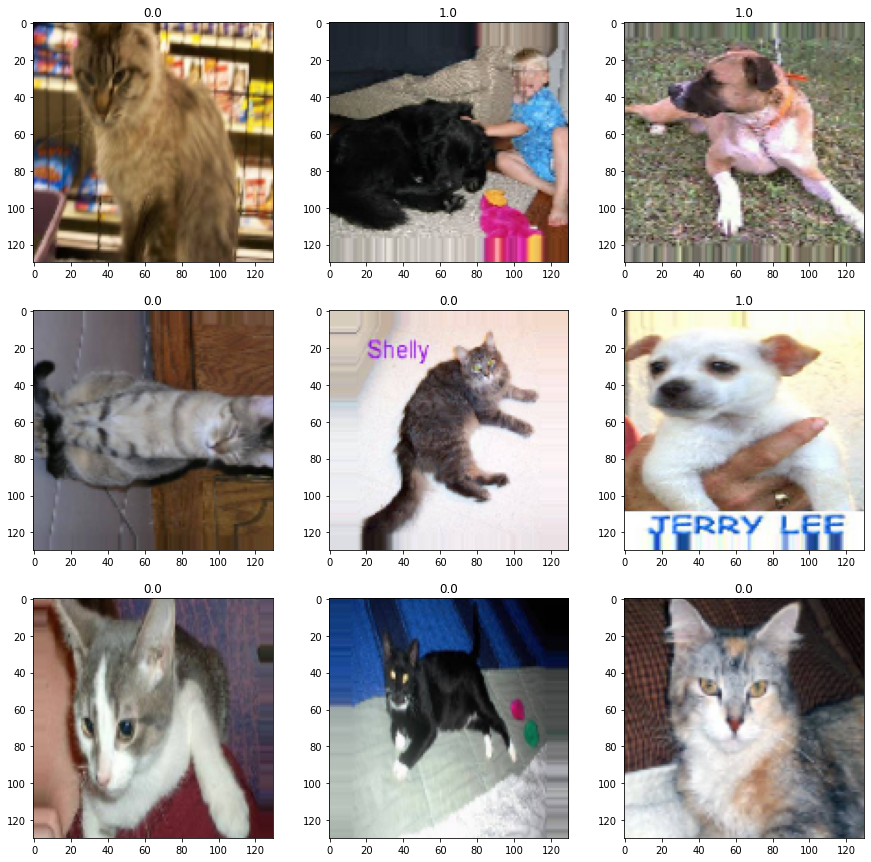

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i in range(9):
    img, label = train_generator.next()
    plt.subplot(331+i)
    plt.imshow(img[0])
    plt.title(label[0])
plt.show()

# Xception

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Apply random data augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
x = data_augmentation(inputs)  

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
___________________________________________

In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, 
          epochs=epochs, 
          validation_data=validation_generator)

Epoch 1/20
547/547 [==============================] - 201s 279ms/step - loss: 0.1803 - binary_accuracy: 0.9241 - val_loss: 0.1614 - val_binary_accuracy: 0.9327
Epoch 2/20
547/547 [==============================] - 154s 282ms/step - loss: 0.1626 - binary_accuracy: 0.9295 - val_loss: 0.1612 - val_binary_accuracy: 0.9307
Epoch 3/20
547/547 [==============================] - 153s 281ms/step - loss: 0.1565 - binary_accuracy: 0.9334 - val_loss: 0.1601 - val_binary_accuracy: 0.9311
Epoch 4/20
547/547 [==============================] - 154s 281ms/step - loss: 0.1579 - binary_accuracy: 0.9373 - val_loss: 0.1528 - val_binary_accuracy: 0.9349
Epoch 5/20
547/547 [==============================] - 154s 282ms/step - loss: 0.1508 - binary_accuracy: 0.9377 - val_loss: 0.1487 - val_binary_accuracy: 0.9364
Epoch 6/20
547/547 [==============================] - 155s 284ms/step - loss: 0.1598 - binary_accuracy: 0.9340 - val_loss: 0.1505 - val_binary_accuracy: 0.9373
Epoch 7/20
547/547 [====================

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
__________________________________________

In [ ]:
predictions = model.predict(test_generator, batch_size=32, verbose =1)
predictions

391/391 [==============================] - 37s 94ms/step


array([[9.9999857e-01],
       [9.9999309e-01],
       [9.9999988e-01],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [4.4571946e-04]], dtype=float32)

In [ ]:
import pandas as pd
import numpy as np
submission = pd.read_csv('sample_submission.csv')
submission['label'] = np.clip(predictions[:,0],0.0125,0.9875)
submission.to_csv('MSBASession1LanChen.csv', index=False)
submission.head()

,id,label
0,1,0.9875
1,2,0.9875
2,3,0.9875
3,4,0.9875
4,5,0.0125


# Manual

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten,Convolution2D,MaxPooling2D,Activation

optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
objective = 'binary_crossentropy'

model = Sequential()
model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(150, 150,3), activation='relu'))
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
model.add(Convolution2D(256,(3, 3), padding='same', activation='relu'))
model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

epochs = 10
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)


Epoch 1/10
547/547 [==============================] - 157s 280ms/step - loss: 0.6800 - accuracy: 0.5505 - val_loss: 0.6638 - val_accuracy: 0.5760
Epoch 2/10
547/547 [==============================] - 151s 277ms/step - loss: 0.6452 - accuracy: 0.6251 - val_loss: 0.6144 - val_accuracy: 0.6672
Epoch 3/10
547/547 [==============================] - 150s 275ms/step - loss: 0.6058 - accuracy: 0.6787 - val_loss: 0.5548 - val_accuracy: 0.7041
Epoch 4/10
547/547 [==============================] - 152s 277ms/step - loss: 0.5488 - accuracy: 0.7239 - val_loss: 0.5691 - val_accuracy: 0.6877
Epoch 5/10
547/547 [==============================] - 152s 277ms/step - loss: 0.5023 - accuracy: 0.7634 - val_loss: 0.4941 - val_accuracy: 0.7716
Epoch 6/10
547/547 [==============================] - 151s 276ms/step - loss: 0.4625 - accuracy: 0.7807 - val_loss: 0.4215 - val_accuracy: 0.7980
Epoch 7/10
547/547 [==============================] - 151s 276ms/step - loss: 0.4348 - accuracy: 0.8014 - val_loss: 0.3997 -

In [ ]:
predictions = model.predict(test_generator, batch_size=32, verbose =1)

In [ ]:
import pandas as pd
submission = pd.read_csv('/content/sample_submission.csv')
submission['label'] = predictions[:,0]
submission.to_csv('MSBASession1LanChen.csv', index=False)
submission.head()

,id,label
0,1,0.977482
1,2,0.000624
2,3,0.697200
3,4,0.999860
4,5,0.856644


# VGG16

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
base_model = keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Apply random data augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
x = data_augmentation(inputs)  

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
# scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
# x = scale_layer(x)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, 
          epochs=epochs, 
          validation_data=validation_generator)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


547/547 [==============================] - 190s 331ms/step - loss: 0.5623 - binary_accuracy: 0.7217 - val_loss: 0.4687 - val_binary_accuracy: 0.8084
Epoch 2/20
547/547 [==============================] - 172s 315ms/step - loss: 0.4480 - binary_accuracy: 0.8047 - val_loss: 0.4115 - val_binary_accuracy: 0.8328
Epoch 3/20
547/547 [==============================] - 171s 313ms/step - loss: 0.4100 - binary_accuracy: 0.8229 - val_loss: 0.3884 - val_binary_accuracy: 0.8375
Epoch 4/20
547/547 [==============================] - 170s 310ms/step - loss: 0.3967 - binary_accuracy: 0.8225 - val_loss: 0.3731 - val_binary_accuracy: 0.8419
Epoch 5/20
547/547 [==============================] - 176s 322ms/step - loss: 0.3816 - binary_accuracy: 0.8309 - val_loss: 0.3690 - val_binary_accuracy: 0.8489
Epoch 6/20
547/547 [==============================] - 169s 310ms/step - loss: 0.3784 - binary_accuracy: 0.8326 - val_loss: 0.3518 - val_binary_accuracy: 0.8496
Epoch 7/20
547/547 [==============================]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________

In [ ]:
predictions = model.predict(test_generator, batch_size=32, verbose =1)
predictions

391/391 [==============================] - 47s 120ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [1.7598349e-07]], dtype=float32)

In [ ]:
import pandas as pd
import numpy as np
submission = pd.read_csv('sample_submission.csv')
submission['label'] = np.clip(predictions[:,0],0.0125,0.9875)
submission.to_csv('MSBASession1LanChen.csv', index=False)
submission.head()

,id,label
0,1,0.9875
1,2,0.9875
2,3,0.9875
3,4,0.9875
4,5,0.0125


# EfficientNetB7

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
base_model = keras.applications.EfficientNetB7(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Apply random data augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
x = data_augmentation(inputs)  

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
# scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
# x = scale_layer(x)

258076736/258076736 [==============================] - 7s 0us/step


In [ ]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, 
          epochs=epochs, 
          validation_data=validation_generator)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2561      
                                                                 
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
___________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


547/547 [==============================] - 229s 378ms/step - loss: 0.7158 - binary_accuracy: 0.5054 - val_loss: 0.7221 - val_binary_accuracy: 0.5001
Epoch 2/20
547/547 [==============================] - 199s 363ms/step - loss: 0.7126 - binary_accuracy: 0.5115 - val_loss: 0.6912 - val_binary_accuracy: 0.5143
Epoch 3/20
547/547 [==============================] - 197s 360ms/step - loss: 0.7090 - binary_accuracy: 0.5156 - val_loss: 0.6871 - val_binary_accuracy: 0.5319
Epoch 4/20
547/547 [==============================] - 198s 363ms/step - loss: 0.7100 - binary_accuracy: 0.5158 - val_loss: 0.6885 - val_binary_accuracy: 0.5279
Epoch 5/20
547/547 [==============================] - 197s 361ms/step - loss: 0.7053 - binary_accuracy: 0.5242 - val_loss: 0.6836 - val_binary_accuracy: 0.5673
Epoch 6/20
547/547 [==============================] - 199s 364ms/step - loss: 0.7040 - binary_accuracy: 0.5245 - val_loss: 0.6892 - val_binary_accuracy: 0.5223
Epoch 7/20
547/547 [==============================]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2561      
                                                                 
Total params: 64,100,248
Trainable params: 63,789,521
Non-trainable params: 310,727
_________________________________________

In [ ]:
predictions = model.predict(test_generator, batch_size=32, verbose =1)
predictions

391/391 [==============================] - 74s 152ms/step


array([[9.9468356e-01],
       [9.9999976e-01],
       [1.0000000e+00],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [4.9111433e-04]], dtype=float32)

In [ ]:
import pandas as pd
import numpy as np
submission = pd.read_csv('sample_submission.csv')
submission['label'] = np.clip(predictions[:,0],0.0125,0.9875)
submission.to_csv('MSBASession1LanChen.csv', index=False)
submission.head()

,id,label
0,1,0.987500
1,2,0.987500
2,3,0.987500
3,4,0.987500
4,5,0.195538


# EB3


In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
base_model = keras.applications.EfficientNetB3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Apply random data augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
x = data_augmentation(inputs)  

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
# scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
# x = scale_layer(x)

43941136/43941136 [==============================] - 3s 0us/step


In [27]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, 
          epochs=epochs, 
          validation_data=validation_generator)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 5, 5, 1536)       10783535  
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_5 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 1536)              0         
                                                                 
 dense_12 (Dense)            (None, 1)                 1537

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

In [ ]:
predictions = model.predict(test_generator, batch_size=32, verbose =1)
predictions

In [ ]:
import pandas as pd
import numpy as np
submission = pd.read_csv('sample_submission.csv')
submission['label'] = np.clip(predictions[:,0],0.0125,0.9875)
submission.to_csv('MSBASession1LanChen.csv', index=False)
submission.head()